# 문제 정의

현재 공유 킥보드나 공유 자전거처럼 공유 서비스를 활용한 인도에서의 이동 수단이 늘어나는 추세다.

그러나, 이러한 공유 이동수단들은 이용 이후에 아무 곳에서나 하차를 하고 놔둘 수 있다는 문제점이 존재하고 이에 따라서 공유 이동수단이 인도가 아닌 위험지역(차도 등)에 있을 경우 이를 식별하는 시스템의 필요성에 따라 해당 시스템에 필요한 객체 탐지 모델을 설계하고자 했다.

이 때, 중요한 점은

- 빠른 속도로 거의 실시간 처리가 가능할 것

- 지속적인 학습으로 모델 업데이트가 용이할 것

- 데이터셋 크기로 인해 Incremental Learning을 구현할 수 있을 것

정도의 필요 조건을 고려하고 객체 탐지 모델을 설계한다. 

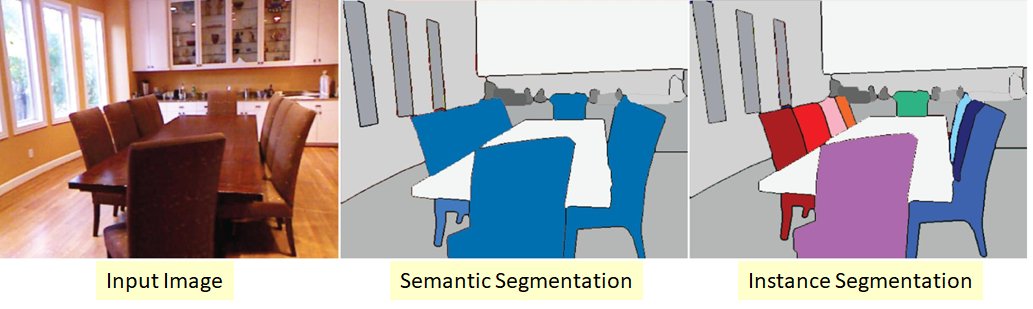

Object detection 기술 중에서 Bounding Box가 아닌 픽셀 단위의 정확도를 가진 Segmentation이 필요하고, 굳이 Instance를 나눠서 각각 개별 객체를 확인할 필요는 없으므로 Semantic Segmentation을 사용

## 데이터셋

https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=189

### 제목 : 인도보행 영상

### 소개


인도 보행에 장애가 되는 객체 29종에 대해 박스, 폴리곤 형태로 어노테이션한 데이터 및 인도 노면 상태 정보를 폴리곤 형태로 어노테이션한 데이터를 구축한 영상 데이터 제공

### 구축목적


장애인 이동권 신장
- 인공지능의 도움으로 장애인 보행에 위협요소인 각종 장애물(자동차, 사람, 가로수, 가로등 등)과 파손 등으로 위험한 보행 노면을 피해 보다 안전하고 원활한 장애인 이동권 보장
인도보행 인공지능 분야 공개데이터 셋의 부족
- 국내 인도보행영상 데이터셋 구축 사례 전무한 상태에서 국내 환경 맞춤형 데이터셋 구축 필요 자율주행 분야에서 차도뿐 아니라 생활도로, 인도 등의 국내 다양한 도로형태에서의 데이터 셋 구축

# AI Hub에서의 데이터 전처리

AI Hub의 데이터는 굉장히 크고, 방대하며 annotation이 잘 되어 있으나 사용하고자 하는 모델에 따라서 다르게 입력값을 조정해주어야 한다.

현재 환경이 가진 RAM과 총 600GB가 넘는 데이터셋의 크기를 감안하여 데이터셋에서 필요한 부분만 추출하고 Task를 위한 적절한 선택이 필요하다고 판단한다.

해당 데이터셋은 "영상" 을 고려하고 annotation을 만들었기에 이미지에서의 Sementic Segmentaiton에서의 annotation과는 다른 부분이 존재한다.

따라서 YOLO v5에 활용 가능한 형태로 바꿔주도록 한다



TODO

- 라벨이 데이터 내의 annotation마다 총 갯수가 다르다
> 처음에 0~n까지의 Label에 특정 사물을 배정시킨 뒤에 훈련시키고 이를 Json 형태(dictionary)로 저장한 뒤 파일을 보존한다. 이후 훈련시킬 때마다 새로운 class가 등장하면 n+1에 배정하고 Json에 저장하는 식으로 기록.

- 향후 추가될 라벨에 대해서 어떻게 처리할지 생각해봐야 함
> YOLO 라이브러리는 pretrained 모델으로 저장하는 기능이 있음. 이걸 활용하여 모델을 훈련시킨 뒤 저장하고, 다시 훈련시키는 식으로 반복하여 진행하는 것을 생각해보자


In [9]:
import xml.etree.ElementTree as ET
xml_anot = ET.parse('/content/0617_01.xml')

In [12]:
root = xml_anot.getroot()

In [ ]:
image_list = []

for child in root:
  if child.tag == 'meta':
    meta = child
  elif child.tag == 'image':
    image_list.append(child)
  print(child.tag, child.attrib)

In [ ]:
image_list

In [34]:
task = meta.find('task')

In [37]:
labels = task.find('labels')

In [39]:
label_list = []

for label in labels:
  label_list.append(label[0].text)

In [40]:
label_dict = {}

for i, label in enumerate(label_list):
  label_dict[label] = i

In [41]:
label_dict

{'wheelchair': 0,
 'truck': 1,
 'tree_trunk': 2,
 'traffic_sign': 3,
 'traffic_light': 4,
 'table': 5,
 'stroller': 6,
 'stop': 7,
 'scooter': 8,
 'potted_plant': 9,
 'pole': 10,
 'person': 11,
 'parking_meter': 12,
 'movable_signage': 13,
 'motorcycle': 14,
 'kiosk': 15,
 'fire_hydrant': 16,
 'dog': 17,
 'chair': 18,
 'cat': 19,
 'carrier': 20,
 'car': 21,
 'bus': 22,
 'bollard': 23,
 'bicycle': 24,
 'bench': 25,
 'barricade': 26}

In [ ]:
data = {}

data['names'] = label_list
data['nc'] = len(label_list)

In [7]:
import yaml
 
with open('data.yaml', 'r') as f:
	data = yaml.load(f, Loader = yaml.FullLoader)

In [8]:
data

{'ang': ['gi', 'modi'],
 'names': ['dog', 'person'],
 'nc': 2,
 'train': '../train/images',
 'val': '../valid/images'}

In [6]:
with open('data.yaml', 'w') as f:
	yaml.dump(data, f)

# YOLO v5 모델 학습

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
import utils
display = utils.notebook_init()  # checks